In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import seaborn as sns

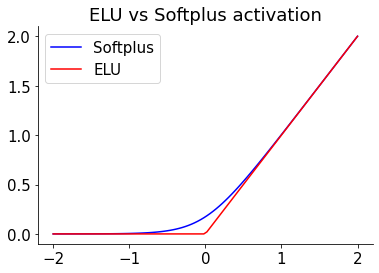

zero input: tensor(0.1733)


In [8]:
a = torch.linspace(-2,2,100)
plt.plot(a,F.softplus(a,beta=4),color='blue',label='Softplus')
plt.plot(a,F.relu(a),color='red',label='ELU')
plt.title('ELU vs Softplus activation')
plt.legend()
sns.despine()
plt.show()

print("zero input:",F.softplus(torch.tensor(0.),beta=4))

In [3]:
def n_choose_k(n,k):
    num_permutations = np.math.factorial(n) / (np.math.factorial(k)*np.math.factorial(n-k))
    return int(num_permutations)

def n_hot_patterns(n,length):
    all_permutations = torch.tensor(list(itertools.product([0., 1.], repeat=length)))
    pattern_hotness = torch.sum(all_permutations,axis=1)
    idx = torch.where(pattern_hotness == n)[0]
    n_hot_patterns = all_permutations[idx]
    return n_hot_patterns

print(n_choose_k(7,2))
n_hot_patterns(n=2,length=4)

21


tensor([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]])

In [110]:
class FBI_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.in_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size 
        
        # Hidden weights
        self.in2hidden = nn.Linear(self.in_size, self.hidden_size, bias=False)
        self.in2hidden.weight.data.uniform_(0,1)

        # Output weights
        self.hidden2output = nn.Linear(self.hidden_size, self.output_size, bias=False)
        self.hidden2output.weight.data.uniform_(0,1)
        

    def forward(self, input_pattern, act_sharpness=4):
        
        hidden = self.in2hidden(input_pattern)
        hidden = F.softplus(hidden, beta=act_sharpness)

        output = self.hidden2output(hidden)
        output = F.softplus(output, beta=act_sharpness)

        return output, hidden
    
        
    def train(self, num_epochs, all_patterns, learning_rate):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]
        
        hidden_history = torch.zeros(self.hidden_size, num_patterns, num_epochs)
        output_history = torch.zeros(self.output_size, num_patterns, num_epochs)
        loss_history = []
        
        for epoch in tqdm(range(num_epochs)):
            for pattern_idx in torch.randperm(num_patterns):
                
                input_pattern = all_patterns[pattern_idx]
                target  = torch.eye(self.output_size)[pattern_idx]
                
                output, hidden = self.forward(input_pattern)

#                 loss = criterion(output, target)
                non_target_idx = [x for x in range(21) if x!=pattern_idx]
                non_target_loss = torch.mean(output[non_target_idx]**2)
                target_loss = 1/(output[pattern_idx]+0.01)
                loss = target_loss + non_target_loss
            
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Recrify the weights
                self.in2hidden.weight.data = self.in2hidden.weight.data.clamp(0,100)
                self.hidden2output.weight.data = self.hidden2output.weight.data.clamp(0,100)
                        
                loss_history.append(loss.detach())   
                output_history[:,pattern_idx,epoch] = output.detach()
                hidden_history[:,pattern_idx,epoch] = hidden.detach()
     
        return output_history, hidden_history, torch.tensor(loss_history)
    

In [111]:
# torch.manual_seed(42)

# Initialize RNN
input_size = 21
hidden_size = 7
output_size = 21

model = FBI_RNN(input_size, hidden_size, output_size)

100%|██████████| 10000/10000 [01:54<00:00, 87.21it/s]


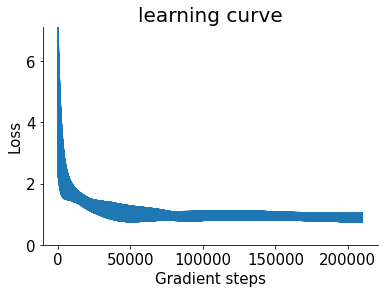

In [112]:
# Train network
num_epochs = 10**4
lr = 0.0001

all_patterns = torch.eye(output_size)

output_history, hidden_history, loss_history = model.train(num_epochs, all_patterns, lr)

plt.plot(loss_history)
plt.xlabel('Gradient steps')
plt.ylabel('Loss')
plt.ylim([0,torch.max(loss_history)])
plt.title('learning curve',fontsize=20)

sns.despine()
plt.show()

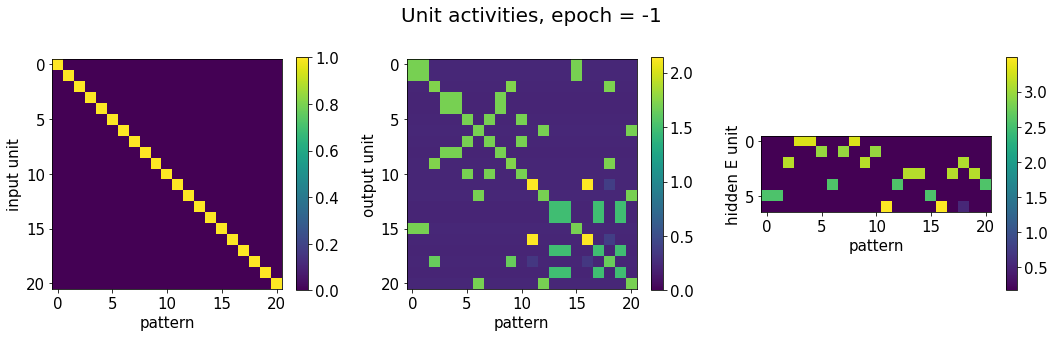

In [113]:
def plot_activity(epoch = -1):
    fig, ax = plt.subplots(1,3,figsize=(15,4.5))
    axis = 0
    im = ax[axis].imshow(all_patterns,aspect='equal',vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,:,epoch],aspect='equal',vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(hidden_history[:,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden E unit')

    plt.suptitle(f"Unit activities, epoch = {epoch}",fontsize=20)
    plt.tight_layout()
    plt.show()
    
plot_activity(-1)

In [93]:
import ipywidgets as widgets
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

In [ ]:
import ipywidgets as widgets

def plot_learning_activity(epoch):
    epoch = epoch*10
    time = -1

    fig, ax = plt.subplots(2,3,figsize=(15,4.5))
    axis = 0,0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 0,1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 0,2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    ax[1,0].axis('off')

    axis = 1,1
    im = ax[axis].imshow(hidden_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden E unit')

    axis = 1,2
    im = ax[axis].imshow(hidden_inh_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden I unit')

    plt.suptitle("Unit activities",fontsize=20)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_learning_activity, epoch=(0,99,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

In [ ]:
def plot_oscillation(epoch):
    
    if epoch > -1:
        epoch = epoch*10
    
    fig, ax = plt.subplots(2,2,figsize=(15,4.5))
    axis = 0,0
    for i in range(model.Eo_size):
        ax[axis].plot(torch.mean(output_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
    ax[axis].set_xlabel('timestep')
    ax[axis].set_ylabel('unit activity')
    ax[axis].set_title('Output units')
    ax[axis].set_ylim(bottom=0)


    axis = 1,0
    for i in range(model.Eh_size):
        ax[axis].plot(torch.mean(hidden_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
    ax[axis].set_xlabel('timestep')
    ax[axis].set_ylabel('unit activity')
    ax[axis].set_title('Hidden E units')
    ax[axis].set_ylim(bottom=0)

    plt.suptitle(f"Unit dynamics over RNN steps, BPTT={num_BPTT_steps}, optimize={eval_step} ",fontsize=20)

    sns.despine()
    plt.tight_layout()
    plt.show()
    

plot_oscillation(-1)

In [ ]:
import ipywidgets as widgets
widgets.interact(plot_oscillation, epoch=(0,99,1));
# widgets.interact(plot_oscillation, epoch=widgets.Play(min=1,max=50));

In [ ]:
import matplotlib.gridspec as gs

fig = plt.figure(figsize=(15, 6))
axes = gs.GridSpec(nrows=3, ncols=3)
#                    left=0.05,right=0.98,
#                    top = 0.95, bottom = 0.2,
#                    wspace=0.8, hspace=1.2)



# Hidden weights
ax = fig.add_subplot(axes[0,0])
im = ax.imshow(model.in2Eh.weight.data,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('input unit')
ax.set_ylabel('Hidden unit')
ax.set_title('in2hidden',fontsize=15)


ax = fig.add_subplot(axes[0,1])
im = ax.imshow(model.Eh2Ih.weight.data.T,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_ylabel('Hidden unit')
ax.set_xlabel('Ih unit')
ax.set_title('hidden2inh',fontsize=15)
ax.get_xaxis().set_visible(False)

ax = fig.add_subplot(axes[0,2])
im = ax.imshow(model.Ih2Eh.weight.data,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('Ih unit')
ax.set_ylabel('hidden unit')
ax.set_title('inh2hidden',fontsize=15)
ax.get_xaxis().set_visible(False)


# Output weights
ax = fig.add_subplot(axes[1:3,0])
im = ax.imshow(model.Eh2Eo.weight.data,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('hidden unit')
ax.set_ylabel('output unit')
ax.set_title('hidden2out',fontsize=15)

ax = fig.add_subplot(axes[1,1])
im = ax.imshow(model.Eo2Io.weight.data.T,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_ylabel('output unit')
ax.set_xlabel('Io unit')
ax.set_title('out2fbi',fontsize=15)
ax.get_xaxis().set_visible(False)

ax = fig.add_subplot(axes[1,2])
im = ax.imshow(model.Io2Eo.weight.data, aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('Io unit')
ax.set_ylabel('output unit')
ax.set_title('fbi2out',fontsize=15)
ax.get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats

x = model.Eo2Io.weight.data.T.flatten()
y = model.Io2Eo.weight.data.flatten()

plt.scatter(x,y)
plt.xlabel('out2fbi weights')
plt.ylabel('fbi2out weights')



m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(-1,1.5,2)
y_fit = m*x_fit + b
plt.plot(x_fit, y_fit, c='red')
# print('Linear regression: y = {} x + {}'.format(m,b))

plt.title(f"T={num_timesteps}, BPTT={num_BPTT_steps}")

sns.despine()
plt.show()

r_val, p_val = stats.pearsonr(x, y)
print('Pearson correlation: r={}, r^2={}, p={}'.format(r_val,r_val**2,p_val))